In [1]:
import requests
import pandas as pd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage, TextArea)
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

In [13]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['LocationID']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['sitecode'], ['Latitude' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['sitecode'], ['Longitude' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

In [14]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False, dwd_data = True):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        if dwd_data:
            self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
            self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
            self.add_locations()
        self.phase_list = [] #list of phases to consider
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False
        self.first_input_array = True

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035, latlon_proj = False):
        self.latlon_proj = latlon_proj
        ## Puts pandas phenological frame into driver xarray and aligns the two
        #self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        if self.first_input_array:
            self.obs_for_GDD = self.phen_data.where(self.phen_data['Eintrittsdatum'] >= np.datetime64('2001-01-01')).dropna()
            x_coords = self.obs_for_GDD['lon'].values
            y_coords = self.obs_for_GDD['lat'].values
            station_ids = np.int64(self.obs_for_GDD['Stations_id'].values)
            x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
            #Makes an array to put into GDD model
            print('project to new coords')
            self.stations = stations
            if not(latlon_proj):
                x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
                self.x_driver_proj = x_epsg
                self.y__driver_proj = y_epsg
            else:
                self.x_driver_proj = x_unique
                self.y__driver_proj = y_unique
            print('interpolate driver to station locations')
            # Working in xarray (not pandas) after this point:
            #print('Latlonproj:', not(latlon_proj))
            self.GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
            self.first_input_array = False
        else: 
            new_GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            new_GDD_driver_data = new_GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                new_GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            new_GDD_driver_data = new_GDD_driver_data.set_xindex(['Stations_id'])
            self.GDD_driver_data = xr.concat([self.GDD_driver_data, new_GDD_driver_data], dim='time')
            self.GDD_driver_data = self.GDD_driver_data.sortby('time')

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        self.obs_for_GDD = self.obs_for_GDD.where(self.obs_for_GDD['Referenzjahr'] <= 2023)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.obs_for_GDD = dataset_fctns.add_SOS_to_df(self.obs_for_GDD)
        self.obs_for_GDD['WC SOS date'] = pd.to_datetime(self.obs_for_GDD['Referenzjahr'], format='%Y') + pd.to_timedelta(self.obs_for_GDD['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.obs_for_GDD[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.obs_for_GDD['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.obs_for_GDD['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False, count_from_SOS = True):
        if count_from_SOS:
            self.phen_data = dataset_fctns.add_SOS_to_df(self.phen_data)
            self.phen_data['WC SOS date'] = pd.to_datetime(self.phen_data['Referenzjahr'], format='%Y') + pd.to_timedelta(self.phen_data['SOS'], 'D')
            self.ds_observed = self.phen_data[['Stations_id', 'Referenzjahr', 'lat', 'lon', 'WC SOS date']].drop_duplicates()
            for phase in self.phase_list:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == phase]
                just_phase= just_phase.assign(**{f'observed time to {phase}': just_phase['Eintrittsdatum'] - just_phase['WC SOS date']})
                self.ds_observed = self.ds_observed.merge(just_phase[[f'observed time to {phase}', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id'])
        else:
            observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
            self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
            for phase in self.phase_list[1:]:
                self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
            self.ds_observed = self.ds_observed.reset_index()
            self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
            self.ds_observed = self.ds_observed.merge(self.obs_for_GDD[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML2(self, driver_variable = 't2m'):
        self.observations_to_use = self.ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(self.ds_observed['Referenzjahr'] >= 2001).dropna().drop_duplicates()
        # make an indexing array to pull values from the array of temperatures
        time_station = xr.Dataset.from_dataframe(self.observations_to_use)
        time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
        #print(time_station)
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')

        ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
        t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        
        #Run model
        for day in range(200):
            # Pull values for temperature out of data frame
            driver_values = self.GDD_driver_data.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
            driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
            driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
            driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
            self.observations_to_use = self.observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
            time_station['time'] += np.timedelta64(1, 'D')
        self.driver_frame_for_ML = self.observations_to_use.merge(self.ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in self.phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] 
        if not(self.latlon_proj):
            time_station['SOS'] += pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML[driver_variable].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_23368\549906624.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [17]:
phen_data_lobell = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\maizedata.lobell.sep2011.csv')
stations_data_lobell = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon.csv')
phen_data_lobell = get_station_locations(phen_data_lobell, stations_data_lobell)
#phen_data_lobell = phen_data_lobell.where(phen_data_lobell['PlantingDate']>10000000)
phen_data_lobell['PlantingDate'] = pd.to_datetime(phen_data_lobell['PlantingDate'], format  = "%Y%m%d")
for colname in ['AnthesisDate', 'DaysToSilk']:
    print(colname)
    phen_data_lobell[colname] = phen_data_lobell['PlantingDate'] + pd.to_timedelta(phen_data_lobell[colname], "D")
#for colname in ['PlantingDate', 'AnthesisDate', 'DaysToSilk']:
#    phen_data_lobell[colname] = phen_data_lobell[colname].dt.dayofyear

AnthesisDate
DaysToSilk


In [23]:
Maize_set_Africa = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\maizedata.lobell.sep2011.csv', raw = False, dwd_data=False)
Maize_set_Africa.phen_data = phen_data_lobell
Maize_set_Africa.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_1999_2000.nc')
Maize_set_Africa.phen_data['Eintrittsdatum'] = Maize_set_Africa.phen_data['PlantingDate']
Maize_set_Africa.phen_data['Stations_id'] = Maize_set_Africa.phen_data['sitecode']
Maize_set_Africa.make_input_array(latlon_proj=True)

project to new coords
interpolate driver to station locations


In [24]:
Maize_set_Africa.GDD_driver_data

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 731, modelpoint: 90)
Coordinates:
    number       int64 8B 0
  * time         (time) datetime64[ns] 6kB 1999-01-01 1999-01-02 ... 2000-12-31
    lon          (modelpoint) float64 720B 12.2 13.43 13.7 ... 38.87 39.28 39.33
    lat          (modelpoint) float64 720B -5.6 -15.03 -9.1 ... -13.24 -15.1 8.4
  * Stations_id  (modelpoint) float64 720B 6.0 10.0 15.0 ... 729.0 736.0 295.0
Dimensions without coordinates: modelpoint
Data variables:
    t2m          (time, modelpoint) float64 526kB 25.49 17.13 ... 25.21 17.79
    t2max        (time, modelpoint) float64 526kB 27.69 23.14 ... 29.05 25.07
    t2min        (time, modelpoint) float64 526kB 24.3 12.03 ... 20.59 12.35
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      125421
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [10]:
T_mean = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_2000.nc')

In [4]:
phen_data_lobell

,logYield,Management,PlantingDate,AnthesisDate,ASI,DaysToSilk,vargroup,yrcode,sitecode,gs150.gdd,...,presilk.tmax2,silk.tmax2,postsilk.tmax2,presilk.gdd830,silk.gdd830,postsilk.gdd830,presilk.gdd30,silk.gdd30,lat,lon
0,2.116713,Optimal,2003-12-05,2004-02-07 16:48:00,2.0,2004-02-09 16:48:00,EPOP,2004,1041,2057.781964,...,803.539520,762.833373,762.645584,742.054326,281.274711,1023.444977,1.125855,0.020164,-14.20,28.40
1,1.859403,Optimal,2003-12-05,2004-02-08 04:48:00,2.0,2004-02-10 04:48:00,ILPO,2004,1041,2057.781964,...,799.009864,767.489960,765.981249,755.186385,282.395275,1009.192354,1.125855,0.020164,-14.20,28.40
2,1.662258,Optimal,2003-12-05,2004-02-12 21:36:00,2.5,2004-02-15 09:36:00,EIHY,2004,1041,2057.781964,...,793.657903,764.914204,779.044136,821.639768,291.092979,934.041267,1.125855,0.020164,-14.20,28.40
3,2.094564,Optimal,2003-12-05,2004-02-10 19:12:00,2.3,2004-02-13 02:24:00,ILHY,2004,1041,2057.781964,...,794.168510,772.895256,773.155186,792.787401,289.850278,964.136335,1.125855,0.020164,-14.20,28.40
4,1.950514,Optimal,2003-12-05,2004-02-11 00:00:00,3.4,2004-02-14 09:36:00,ILHY,2004,1041,2057.781964,...,793.751548,770.235062,775.340270,807.085180,291.329302,948.359532,1.125855,0.020164,-14.20,28.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26137,-1.044977,Optimal,2007-01-18,NaT,NaN,NaT,EPOP,2007,731,2753.377492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.84,38.26
26138,-0.868930,Optimal,2007-01-18,NaT,NaN,NaT,EPOP,2007,731,2753.377492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.84,38.26
26139,-0.621571,Optimal,2007-01-18,NaT,NaN,NaT,EPOP,2007,731,2753.377492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.84,38.26
26140,-0.696954,Optimal,2007-01-18,NaT,NaN,NaT,EPOP,2007,731,2753.377492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.84,38.26


In [7]:
phen_data_lobell = phen_data_lobell.where(phen_data_lobell['yrcode'] <2001).dropna(how='all')

In [9]:
phen_data_lobell

,logYield,Management,PlantingDate,AnthesisDate,ASI,DaysToSilk,vargroup,yrcode,sitecode,gs150.gdd,...,presilk.tmax2,silk.tmax2,postsilk.tmax2,presilk.gdd830,silk.gdd830,postsilk.gdd830,presilk.gdd30,silk.gdd30,lat,lon
460,1.051846,Optimal,1999-11-10,2000-02-10 00:00:00,6.0,2000-02-16 00:00:00,EPOP,2000.0,517.0,1833.331735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.28,27.50
461,0.881645,Optimal,1999-11-10,2000-02-11 00:00:00,6.2,2000-02-17 04:48:00,EPOP,2000.0,517.0,1833.331735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.28,27.50
462,0.992055,Optimal,1999-11-10,2000-02-11 00:00:00,5.3,2000-02-16 07:12:00,EPOP,2000.0,517.0,1833.331735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.28,27.50
463,1.151034,Optimal,1999-11-10,2000-02-07 02:24:00,9.8,2000-02-16 21:36:00,EPOP,2000.0,517.0,1833.331735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.28,27.50
464,0.968834,Optimal,1999-11-10,2000-02-09 07:12:00,6.6,2000-02-15 21:36:00,EPOP,2000.0,517.0,1833.331735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.28,27.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23312,1.365224,Optimal,1999-04-20,1999-06-23 09:36:00,NaN,NaT,ILPO,1999.0,501.0,2578.558434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.93,39.75
23313,1.535533,Optimal,1999-04-20,1999-06-15 12:00:00,NaN,NaT,ILPO,1999.0,501.0,2578.558434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.93,39.75
23314,1.845774,Optimal,1999-04-20,1999-06-19 21:36:00,NaN,NaT,ILPO,1999.0,501.0,2578.558434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.93,39.75
23315,1.809747,Optimal,1999-04-20,1999-06-18 00:00:00,NaN,NaT,ILPO,1999.0,501.0,2578.558434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.93,39.75


In [14]:
phen_data_lobell[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\CIMMYT_coords_2000_2007.csv')

In [5]:
len(phen_data_lobell)#['yrcode'].unique()#.columns

26142

In [11]:
phen_data_lobell.columns

Index(['logYield', 'Management', 'PlantingDate', 'AnthesisDate', 'ASI',
       'DaysToSilk', 'vargroup', 'yrcode', 'sitecode', 'gs150.gdd', 'days30C',
       'anth.precip', 'days35C', 'days40C', 'gs150.tmean', 'tavg2', 'ASI.1',
       'postsilk.gdd30', 'gs150.precip', 'gs150.tmax', 'tmax2', 'presilk.tmin',
       'silk.tmin', 'post45silk.tmin', 'presilk.tmax', 'silk.tmax',
       'post45silk.tmax', 'gs150.tmin', 'tmin2', 'presilk.tmax2', 'silk.tmax2',
       'postsilk.tmax2', 'presilk.gdd830', 'silk.gdd830', 'postsilk.gdd830',
       'presilk.gdd30', 'silk.gdd30', 'lat', 'lon'],
      dtype='object')

In [13]:
phen_data_lobell.drop_duplicates(subset=['AnthesisDate', 'DaysToSilk', 'PlantingDate', 'yrcode', 'sitecode', 'vargroup', 'Management'])#.columns

,logYield,Management,PlantingDate,AnthesisDate,ASI,DaysToSilk,vargroup,yrcode,sitecode,gs150.gdd,...,presilk.tmax2,silk.tmax2,postsilk.tmax2,presilk.gdd830,silk.gdd830,postsilk.gdd830,presilk.gdd30,silk.gdd30,lat,lon
0,2.116713,Optimal,339,38.0,2.0,40.0,EPOP,2004,1041,2057.781964,...,803.539520,762.833373,762.645584,742.054326,281.274711,1023.444977,1.125855,0.020164,-14.20,28.40
1,1.859403,Optimal,339,39.0,2.0,41.0,ILPO,2004,1041,2057.781964,...,799.009864,767.489960,765.981249,755.186385,282.395275,1009.192354,1.125855,0.020164,-14.20,28.40
2,1.662258,Optimal,339,43.0,2.5,46.0,EIHY,2004,1041,2057.781964,...,793.657903,764.914204,779.044136,821.639768,291.092979,934.041267,1.125855,0.020164,-14.20,28.40
3,2.094564,Optimal,339,41.0,2.3,44.0,ILHY,2004,1041,2057.781964,...,794.168510,772.895256,773.155186,792.787401,289.850278,964.136335,1.125855,0.020164,-14.20,28.40
4,1.950514,Optimal,339,42.0,3.4,45.0,ILHY,2004,1041,2057.781964,...,793.751548,770.235062,775.340270,807.085180,291.329302,948.359532,1.125855,0.020164,-14.20,28.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26109,0.224902,Optimal,353,NaN,NaN,NaN,EPOP,2007,737,2664.724561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.49,34.75
26110,0.260593,Low N,353,NaN,NaN,NaN,EPOP,2007,737,2664.724561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.49,34.75
26115,0.358443,Optimal,353,51.0,7.7,59.0,EPOP,2007,737,2664.724561,...,998.961558,923.925704,910.157176,1136.684942,386.561154,1126.528828,26.132569,2.343041,-24.49,34.75
26116,0.384378,Low N,353,51.0,7.2,58.0,EPOP,2007,737,2664.724561,...,997.288191,935.723189,913.063684,1118.321329,387.934531,1143.519063,25.433197,3.042413,-24.49,34.75


In [233]:
len(phen_data_lobell['sitecode'].unique())

26142

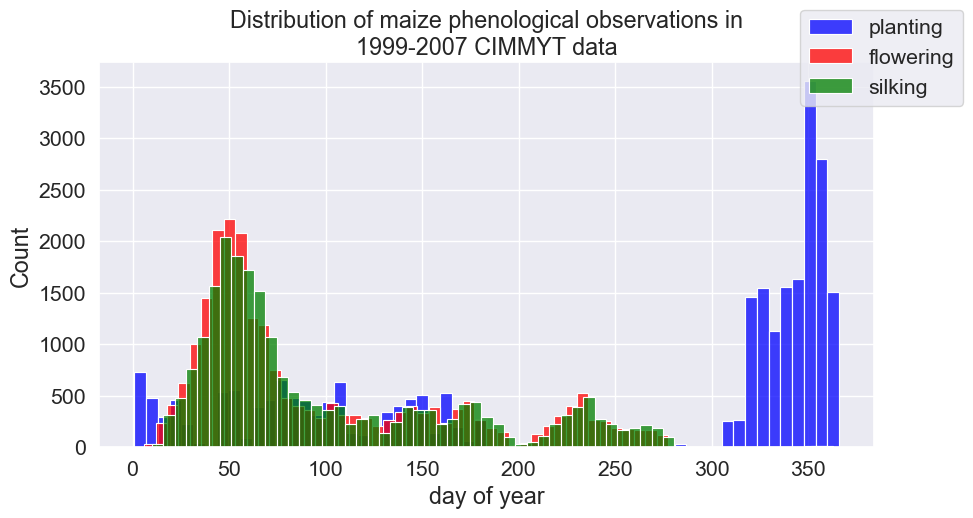

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(data=phen_data_lobell, x="PlantingDate", bins =60, ax=ax, color='blue', label = 'planting')
sns.histplot(data=phen_data_lobell, x='AnthesisDate', bins =60, ax=ax, color='red', label = 'flowering')
sns.histplot(data=phen_data_lobell, x='DaysToSilk', bins =60, ax=ax, color='green', label = 'silking')
sns.set(font_scale=1.4)
ax.set(xlabel='day of year', ylabel='Count', title='Distribution of maize phenological observations in\n1999-2007 CIMMYT data')
fig.legend()
fig.savefig('plots/CIMMYT_phenology_distn.png', bbox_inches='tight')

In [25]:
def rename_TAMASA(ds):
    ds = ds.rename(columns = {'experiment_year=EXPyer': 'year', 
                             'experiment_country=EXPcty': 'country',
                             'Experiment Zone. = EXPzon': 'zone', 
                             'Experiment Region = EXPreg': 'region',
                             'Experiment District=EXPdstr': 'district', 
                             'Experiment station=EXPsdt': 'station',
                             'GPS Coordite Latitude': 'lat', 
                             'GPS Coordite Longitude': 'lon',
                             'GPS Coordite Altitude': 'altitude', 
                             'Maize variety me = MVm': 'maize variety',
                             'Planting date treatment = PLNTRT': 'Planting date treatment', 
                             'Planting date = PLNdat': 'planting date',
                             'Replicate = EXPrep': 'replicate', 
                             'Plot number = PLOTnumb': 'plot number', 
                             'Plot size (sq. m)': 'plot size',
                             'Emergence date = EMdat': 'emergence date',
                             'Tasseling_silking_date=flowering_date = FLWdat': 'flowering date',
                             'Pysioligic_ maturity_dat = MDAT': 'maturity date',
                             'Pysioligic_ maturity_dat = MDAT/date': 'maturity date'})
    return ds

In [26]:
def TAMASA_convert_to_datetime(ds):
    ds = ds.where(ds['emergence date'].str.contains('/')).dropna(how='all')
    #ds = ds.drop([f'Unnamed: {n}' for n in range(26, 53)], axis = 1)
    for colname in ['emergence date', 'flowering date', 'maturity date']:
        print(colname)
        ds[colname] = pd.to_datetime(ds[colname], format  = "%d/%m/%Y")#.dt.dayofyear
    return ds

In [27]:
phen_data2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Tanzania\\TAMASA_TZ_VT__2016.csv')
phen_data_ET = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Tanzania\\TAMASA_ET_VT_2016F.csv')
phen_data2 = rename_TAMASA(phen_data2)
phen_data_ET = rename_TAMASA(phen_data_ET)
phen_data_ET = phen_data_ET.drop([f'Unnamed: {n}' for n in range(26, 53)], axis = 1)
phen_data2 = TAMASA_convert_to_datetime(phen_data2)
phen_data_ET = TAMASA_convert_to_datetime(phen_data_ET)
#pd2 = phen_data2[['emergence date', 'flowering date', 'maturity date']]
#pd2.loc[:, 'date?'] = pd2.loc[:, 'emergence date'].str.contains('/')
#print(phen_data2['emergence date'].str.contains('/'))


emergence date
flowering date
maturity date
emergence date
flowering date
maturity date


In [30]:
phen_data_ET = phen_data_ET.rename(columns = {'GPS Coordinate Latitude': 'lat', 'GPS Coordinate Longitude': 'lon'})
phen_data2 = phen_data2.rename(columns = {'GPS Coordinate Latitude': 'lat', 'GPS Coordinate Longitude': 'lon'})

In [31]:
phen_data_ET.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Tanzania\\TAMASA_Ethiopia.csv')
phen_data2.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Tanzania\\TAMASA_Tanzania.csv')

In [63]:
phen_data2['emergence date'].min()

Timestamp('2015-12-11 00:00:00')

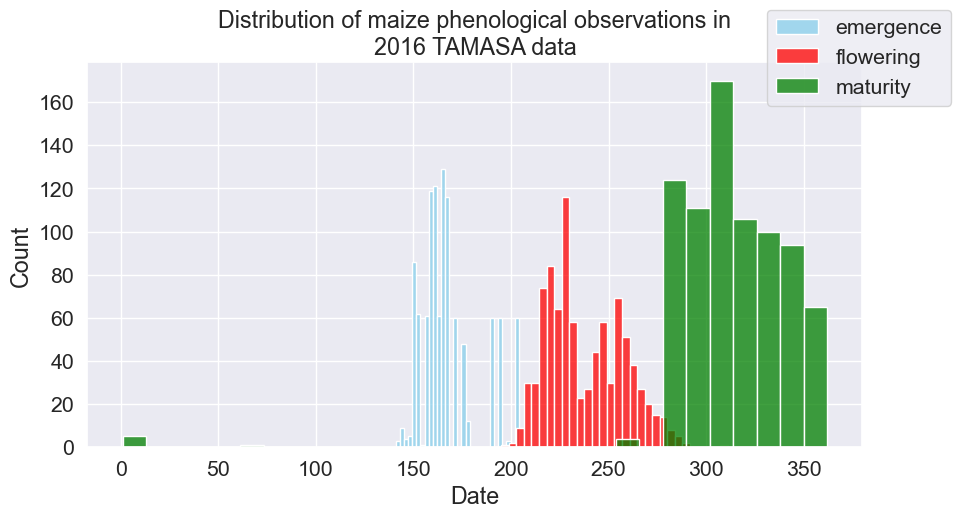

In [46]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(data=phen_data_ET, x="emergence date", bins =30, ax=ax, color='skyblue', label = 'emergence')
sns.histplot(data=phen_data_ET, x="flowering date", bins =30, ax=ax, color='red', label = 'flowering')
sns.histplot(data=phen_data_ET, x="maturity date", bins =30, ax=ax, color='green', label = 'maturity')
sns.set(font_scale=1.4)
ax.set(xlabel='Date', ylabel='Count', title='Distribution of maize phenological observations in\n2016 TAMASA data')
fig.legend()
fig.savefig('plots/comparison_Ethiopia_phenology_distn.png', bbox_inches='tight')

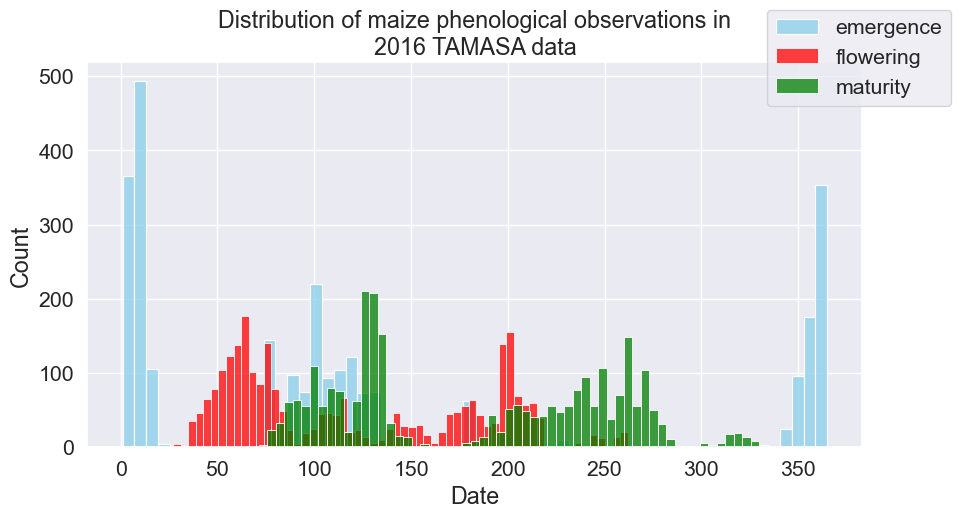

In [169]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(data=phen_data2, x="emergence date", bins =60, ax=ax, color='skyblue', label = 'emergence')
sns.histplot(data=phen_data2, x="flowering date", bins =60, ax=ax, color='red', label = 'flowering')
sns.histplot(data=phen_data2, x="maturity date", bins =60, ax=ax, color='green', label = 'maturity')
sns.set(font_scale=1.4)
ax.set(xlabel='Date', ylabel='Count', title='Distribution of maize phenological observations in\n2016 TAMASA data')
fig.legend()
fig.savefig('plots/comparison_Tanzania_phenology_distn.png', bbox_inches='tight')

In [60]:
phen_data2['emergence date'].min()

1

In [8]:
phen_data2.columns.to_list()

['year',
 'country',
 'zone',
 'region',
 'district',
 'station',
 'lat',
 'lon',
 'altitude',
 'maize variety',
 'Planting date treatment',
 'planting date',
 'replicate',
 'plot number',
 'plot size',
 'emergence date',
 'flowering date',
 'maturity date']

In [9]:
phen_data_ET[['station', 'GPS Coordinate Latitude', 'GPS Coordinate Longitude', 'planting date', 'emergence date', 'flowering date', 'maturity date']].dropna(how='all').to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\TAMASA_Ethiopia_coords.csv')
phen_data2[['station', 'lat', 'lon', 'planting date', 'emergence date', 'flowering date', 'maturity date']].dropna(how='all').drop_duplicates().to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\TAMASA_Tanzania_coords.csv')

In [3]:
phen_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lacuna_Kenya\\lacuna_data0.csv')
for start_code in range (5, 51, 5):
    phen_data = pd.concat([phen_data, pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lacuna_Kenya\\lacuna_data{start_code}.csv')], axis = 0)

In [4]:
phen_data_maize = phen_data.where(phen_data['crop_name']=='maize').dropna()
phen_data_maize = phen_data_maize.where(phen_data_maize['growth_stage'].isin(['M', 'F', 'V'])).dropna(how='all')
phen_data_maize['date'] = pd.to_datetime(phen_data_maize['date']).dt.dayofyear
#phen_data_maize['days since 1st June'] = phen_data_maize['date'] - np.datetime64('2020-06-01')
phen_data_maize = phen_data_maize.reset_index()

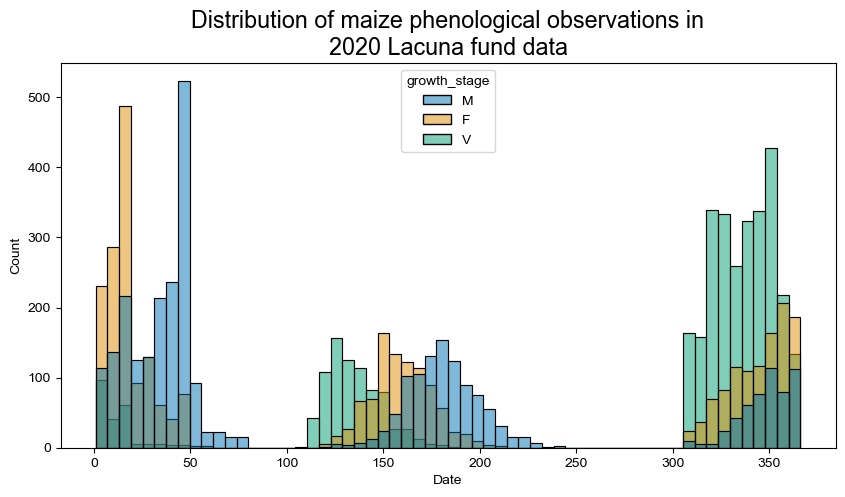

In [5]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(data=phen_data_maize, x="date", hue="growth_stage", bins =60, ax=ax, palette = 'colorblind')
sns.set(font_scale=1.4)
ax.set(xlabel='Date', ylabel='Count', title='Distribution of maize phenological observations in\n2020 Lacuna fund data')
fig.savefig('plots/comparison_Kenya_phenology_distn.png', bbox_inches='tight')

In [8]:
(phen_data['east'] - phen_data['west']).mean()
(phen_data['north'] - phen_data['south']).mean()

0.32209080892369246

In [26]:
phen_data['lon'] = (phen_data['east'] + phen_data['west'])/2
phen_data['lat'] = (phen_data['north'] + phen_data['south'])/2
phen_data_maize['lon'] = (phen_data_maize['east'] + phen_data_maize['west'])/2
phen_data_maize['lat'] = (phen_data_maize['north'] + phen_data_maize['south'])/2

In [8]:
def Kenya_plot():
    adm1_shapes = list(shpreader.Reader('gadm41_KEN_1/gadm41_KEN_1.shp').geometries())
    fig,ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines(resolution='10m')
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='none', alpha=1)
    ax.set_extent([32.5, 43, -6, 5.5], ccrs.PlateCarree())
    return fig, ax

In [129]:
def Tanzania_plot():
    adm1_shapes = list(shpreader.Reader('gadm41_TZA_1/gadm41_TZA_1.shp').geometries())
    fig,ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines(resolution='10m')
    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='none', alpha=1)
    ax.set_extent([27.5, 42, -13.5, 0.5], ccrs.PlateCarree())
    return fig, ax

In [223]:
def SSA_plot():
    fig,ax=plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines(resolution='10m')
    ax.set_extent([0, 50, -60, 20], ccrs.PlateCarree())
    ax.add_feature(cf.BORDERS)
    return fig, ax

In [215]:
latlon

,lon,lat
0,-14.200,28.400
406,-29.280,27.500
621,-28.880,28.050
697,-26.553,31.165
806,-17.783,31.317
...,...,...
25816,-20.380,28.500
25933,-13.240,38.870
26025,-29.550,27.780
26067,-24.490,34.750


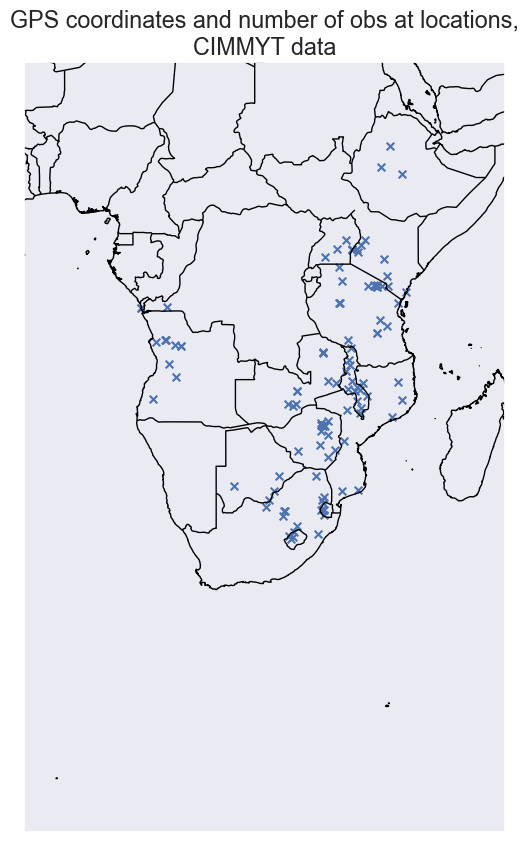

In [226]:
latlon = phen_data_lobell[['lon', 'lat']].drop_duplicates()
#left, bottom, width, height = (33.3, -0.5, 2, 2)
#rect3 = plt.Rectangle((left, bottom), width, height,
#                     facecolor="red", alpha=0.3)
#left, bottom, width, height = (36.4, -2.7, 2.2, 3.2)
#rect4 = plt.Rectangle((left, bottom), width, height,
#                     facecolor="red", alpha=0.3)
#print(left, bottom, width, height)
fig, ax = SSA_plot()
ax.scatter(latlon['lon'], latlon['lat'], s = 30.5, marker='x')
#for location_index in range(len(location_counts)): 
#    print(location_counts['emergence date'][location_index].astype('str'), location_counts['lon 2dp'][location_index], location_counts['lat 2dp'][location_index])
#    plt.annotate(location_counts['emergence date'][location_index].astype('str'), (location_counts['lon 2dp'][location_index], location_counts['lat 2dp'][location_index]),
#                 textcoords='offset points', xytext = (-15, -15), fontsize = 11)


ax.set_title('GPS coordinates and number of obs at locations,\nCIMMYT data')
fig.savefig('plots/CIMMYT_Locations')

(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: >)

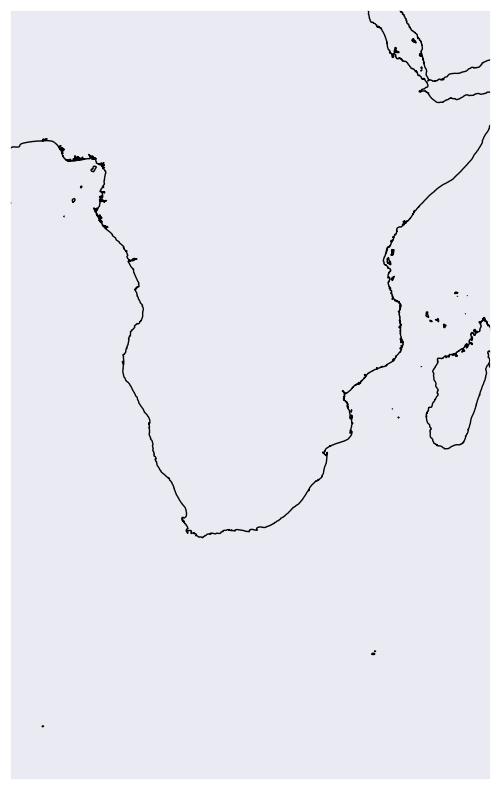

In [211]:
SSA_plot()

In [146]:
phen_data2.drop_duplicates(subset = ['lat', 'lon'])
phen_data2['lat 2dp'] = phen_data2['lat'].round(decimals = 2)
phen_data2['lon 2dp'] = phen_data2['lon'].round(decimals = 2)
location_counts = phen_data2.groupby(['lat 2dp', 'lon 2dp']).count()['emergence date'].reset_index()#.get_level_values(0)

324 36.08 -10.54
324 34.71 -9.53
324 33.63 -9.4
320 33.52 -8.92
324 35.7 -7.79
224 37.68 -3.64
144 37.45 -3.42
223 36.63 -3.36
222 36.41 -3.24
175 37.08 -3.02


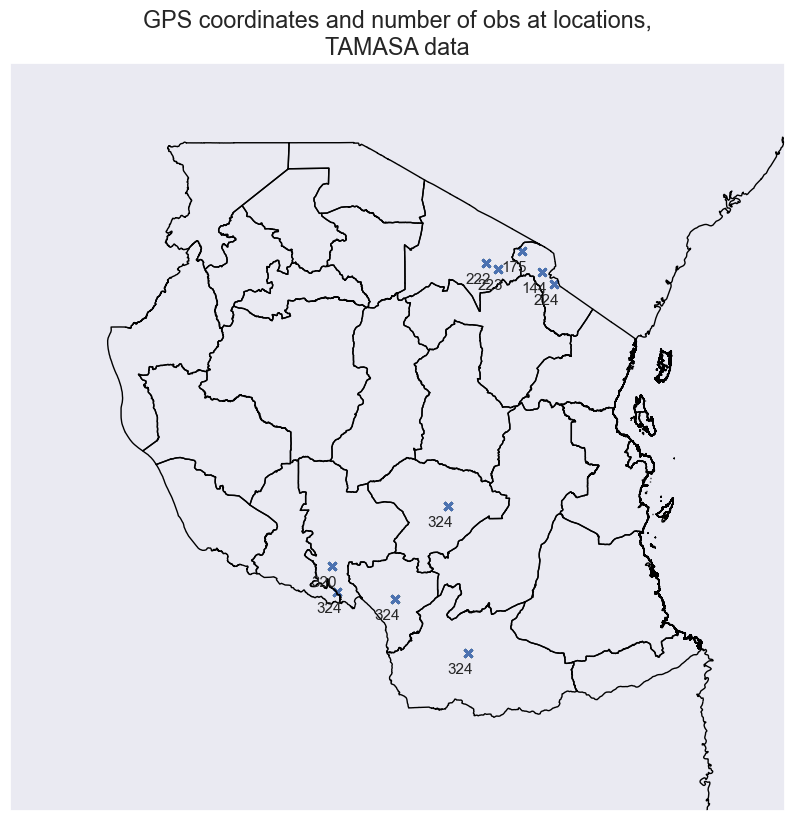

In [160]:
latlon = phen_data2[['lon', 'lat']].drop_duplicates()
#left, bottom, width, height = (33.3, -0.5, 2, 2)
#rect3 = plt.Rectangle((left, bottom), width, height,
#                     facecolor="red", alpha=0.3)
#left, bottom, width, height = (36.4, -2.7, 2.2, 3.2)
#rect4 = plt.Rectangle((left, bottom), width, height,
#                     facecolor="red", alpha=0.3)
#print(left, bottom, width, height)
fig, ax = Tanzania_plot()
ax.scatter(latlon['lon'], latlon['lat'], s = 30.5, marker='x')
for location_index in range(len(location_counts)): 
    print(location_counts['emergence date'][location_index].astype('str'), location_counts['lon 2dp'][location_index], location_counts['lat 2dp'][location_index])
    plt.annotate(location_counts['emergence date'][location_index].astype('str'), (location_counts['lon 2dp'][location_index], location_counts['lat 2dp'][location_index]),
                 textcoords='offset points', xytext = (-15, -15), fontsize = 11)


ax.set_title('GPS coordinates and number of obs at locations,\nTAMASA data')
fig.savefig('plots/TAMASA_Locations')

In [30]:
maize_phen_western = phen_data_maize.where((phen_data_maize['lon'] > 33.3)*(phen_data_maize['lon'] < 35.3)*(phen_data_maize['lat'] > -0.5)*(phen_data_maize['lat'] < 1.5)).dropna()
maize_phen_central = phen_data_maize.where((phen_data_maize['lon'] > 36.4)*(phen_data_maize['lon'] < 38.6)*(phen_data_maize['lat'] > -2.7)*(phen_data_maize['lat'] < 0.5)).dropna()

In [46]:
phen_data['season'].unique()

array(['SR2020', 'LR2020'], dtype=object)

In [47]:
SR_obs_western = maize_phen_western.where(maize_phen_western['season'] == 'SR2020').dropna()
LR_obs_western = maize_phen_western.where(maize_phen_western['season'] == 'LR2020').dropna()
SR_obs_central = maize_phen_central.where(maize_phen_central['season'] == 'SR2020').dropna()
LR_obs_central = maize_phen_central.where(maize_phen_central['season'] == 'LR2020').dropna()

36.4 -2.7 2.2 3.2


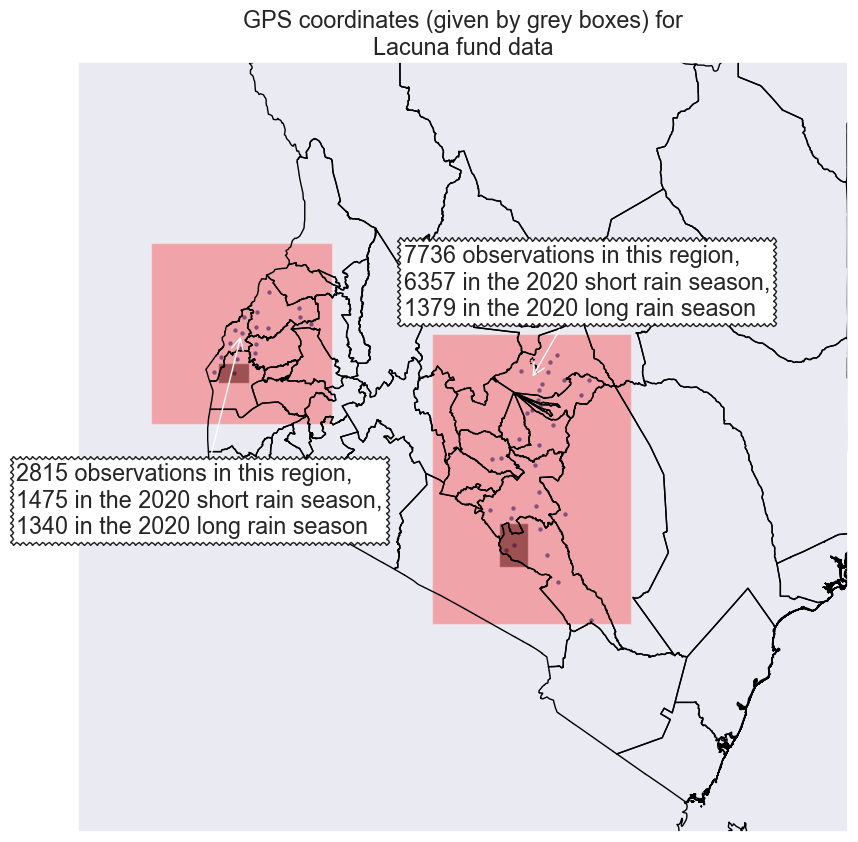

In [53]:
latlon = phen_data_maize[['lon', 'lat']].drop_duplicates()
eastsouth = phen_data_maize[['east', 'south']].drop_duplicates()
westnorth = phen_data_maize[['west', 'north']].drop_duplicates()
obs_index = 0
left, bottom, width, height = (westnorth['west'].values[obs_index], eastsouth['south'].values[obs_index], eastsouth['east'].values[obs_index] - westnorth['west'].values[obs_index], westnorth['north'].values[obs_index] - eastsouth['south'].values[obs_index])
rect1 = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.5)
obs_index = 15
left, bottom, width, height = (westnorth['west'].values[obs_index], eastsouth['south'].values[obs_index], eastsouth['east'].values[obs_index] - westnorth['west'].values[obs_index], westnorth['north'].values[obs_index] - eastsouth['south'].values[obs_index])
rect2 = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.5)
left, bottom, width, height = (33.3, -0.5, 2, 2)
rect3 = plt.Rectangle((left, bottom), width, height,
                     facecolor="red", alpha=0.3)
left, bottom, width, height = (36.4, -2.7, 2.2, 3.2)
rect4 = plt.Rectangle((left, bottom), width, height,
                     facecolor="red", alpha=0.3)
print(left, bottom, width, height)
fig, ax = Kenya_plot()
ax.set_extent([32.5, 41, -5, 3.5], ccrs.PlateCarree())
ax.scatter(latlon['lon'], latlon['lat'], s = 4.5)
#ax.scatter(westnorth['west'], westnorth['north'])
#ax.scatter(eastsouth['east'], eastsouth['south'])
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

xy_central = (37.5, 0)
ax.plot(xy_central[0], xy_central[1], ".r", alpha = 0)

# Annotate the 1st position with a text box ('Test 1')
text_central = TextArea(f"{len(maize_phen_central)} observations in this region,\n{len(SR_obs_central)} in the 2020 short rain season,\n{len(LR_obs_central)} in the 2020 long rain season")

ab_central = AnnotationBbox(text_central, xy_central,
                    xybox=(40, 70),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"),
                    bboxprops=dict(boxstyle="sawtooth"))
ax.add_artist(ab_central)

xy_western = (34.3, 0.5)
ax.plot(xy_western[0], xy_western[1], ".r", alpha = 0)

# Annotate the 1st position with a text box ('Test 1')
text_western = TextArea(f"{len(maize_phen_western)} observations in this region,\n{len(SR_obs_western)} in the 2020 short rain season,\n{len(LR_obs_western)} in the 2020 long rain season")

ab_western = AnnotationBbox(text_western, xy_western,
                    xybox=(-30, -120),
                    xycoords='data',
                    boxcoords="offset points",
                    arrowprops=dict(arrowstyle="->"),
                    bboxprops=dict(boxstyle="sawtooth"))
ax.add_artist(ab_western)
ax.set_title('GPS coordinates (given by grey boxes) for\nLacuna fund data')
fig.savefig('plots/Lacuna_Locations')

In [21]:
phen_data.dropna(subset = ['growth_stage']) #where(np.isnan(phen_data['growth_stage']))
#type(phen_data['growth_stage'].unique()[2])

,Unnamed: 0,farmer_unique_id,site_id,date,filename,season,growth_stage,damage,extent,drought_probability,...,disturbance_none,disturbance_weeds,disturbance_drought,disturbance_nutrient_deficit,crop_name,spatial_location,west,south,east,north
0,0,BS004,509,2020-12-14,L1153F00041C01S00509Rp05636.jpg,SR2020,M,DR,20.0,0.3214,...,0.3129,0.5825,0.0981,0.006500,maize,Alego-Usonga,34.044209,-0.043956,34.390064,0.174809
1,1,BS004,509,2020-12-04,L1153F00041C01S00509Rp02870.jpg,SR2020,F,WD,20.0,0.0354,...,0.0169,0.9813,0.0016,0.000200,maize,Alego-Usonga,34.044209,-0.043956,34.390064,0.174809
2,2,BS004,509,2020-11-27,L1153F00041C01S00509Rp01568.jpg,SR2020,F,WD,40.0,0.2783,...,0.0734,0.9140,0.0080,0.004600,maize,Alego-Usonga,34.044209,-0.043956,34.390064,0.174809
3,3,BS004,509,2020-12-10,L1153F00041C01S00509Rp03796.jpg,SR2020,M,WD,40.0,0.6245,...,0.0584,0.9005,0.0253,0.015800,maize,Alego-Usonga,34.044209,-0.043956,34.390064,0.174809
4,4,BS004,509,2020-12-14,L1153F00041C01S00509Rp05635.jpg,SR2020,M,WD,20.0,0.4625,...,0.1189,0.7705,0.0625,0.048200,maize,Alego-Usonga,34.044209,-0.043956,34.390064,0.174809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,118,349190,1306,2020-11-06,L353F02184C01S01306Ip.jpg,SR2020,V,G,0.0,0.0299,...,0.0420,0.9572,0.0008,0.000009,maize,unknown-5,37.792473,-0.065796,37.937317,0.048834
120,120,3951797,3643,2020-11-15,L353F02684C01S03643Ip.jpg,SR2020,F,WD,20.0,0.1344,...,0.0558,0.9432,0.0009,0.000000,maize,unknown-5,37.792473,-0.065796,37.937317,0.048834
121,121,4096982,3575,2020-11-15,L353F02807C01S03575Ip.jpg,SR2020,V,G,0.0,0.0104,...,0.1228,0.8719,0.0053,0.000002,maize,unknown-5,37.792473,-0.065796,37.937317,0.048834
122,122,4848010,3189,2020-11-12,L353F03362C01S03189Ip.jpg,SR2020,V,WD,10.0,0.0761,...,0.1291,0.8650,0.0059,0.000100,maize,unknown-5,37.792473,-0.065796,37.937317,0.048834


## Note: M Mature, F flowering, V something else? Not sure...

In [2]:
full_catalog_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images/catalog.json'
full_catalog_info = requests.get(full_catalog_url)
first = True
for location_info in full_catalog_info.json()['links']:
    labels = []
    if location_info['rel'] == 'child':
        location_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images' + location_info['href'][1:]
        catalog_info = requests.get(location_url)
        print(catalog_info.json()['id'])
        image_links = catalog_info.json()['links']
        locs = catalog_info.json()['extent']['spatial']['bbox'][0]
        for index, infos in enumerate(image_links):
            #print(index)
            if index % 50 == 0:
                print(index)
            image_info_location = infos['href']
            image_info = requests.get(image_info_location)
            if 'assets' in image_info.json().keys():
                image_label_location = image_info.json()['assets']['label']['href']
                image_label = requests.get(image_label_location).json()
                labels.append(image_label[0])
        dataframe_to_add = pd.DataFrame(labels)
        dataframe_to_add['west'] = locs[0]
        dataframe_to_add['south'] = locs[1]
        dataframe_to_add['east'] = locs[2]
        dataframe_to_add['north'] = locs[3]
        if first:
            phen_data = dataframe_to_add
            first = False
        else:
            phen_data = pd.concat([phen_data, dataframe_to_add])

Alego-Usonga
Budalangi
Bumula
Butula
Buuri
Central-Imenti
Chuka_Igambang'Ombe
Funyula
Gatanga
Igembe-South


: 

In [10]:
phen_data.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lacuna_Kenya\\phen_data.csv')

In [ ]:
location_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images/Alego-Usonga/collection.json'

    #print(infos['href'])
    #print(infos['rel'])
    #print(infos['type'])

In [ ]:
df_to_export = phen_data_maize[['lat', 'lon', 'spatial_location', 'west', 'south', 'east', 'north']]
df_to_export.drop_duplicates().values
np.savetxt('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords_Kenya.csv', 
            df_to_export.drop_duplicates().values, fmt = '%s')
np.loadtxt('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords_Kenya.csv', 
           dtype =  {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f4', 'f4', 'S20', 'f4', 'f4', 'f4', 'f4')})

KeyError: "['lat', 'lon'] not in index"